<a href="https://colab.research.google.com/github/Alton01/neural_network_pytorch_classification/blob/main/neural_network_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples=n_samples,
                    noise=0.03, # noise is for randomess
                    random_state=42) # equivalent to setting a random seed. flavoring the randomness

In [2]:
# Make dataframe of circle data
import pandas as pd

# pd.DataFrame(...): Creates a pandas DataFrame called circles
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10) # Displays the first 10 rows of the circles DataFrame

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


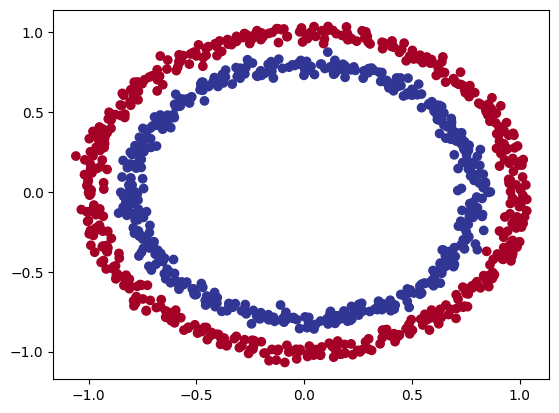

In [3]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu) # cmap stands for color map

In [4]:
X.shape, y.shape # .shape attribute in NumPy. X has 1000 rows and 2 columns. y is the outcome, y is a 1-dimensional array with 1 value

((1000, 2), (1000,))

In [5]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [6]:
# turn data into tensors

import torch
torch.__version__

# torch.from_numpy(X): Converts the NumPy array X into a PyTorch tensor. numpys dtype(data type is float 64)
# .type(torch.float): Casts the data type of the tensor to torch.float (32-bit floating point). This is a common data type for neural network inputs.
# Converting data to tensors is a crucial step when working with deep learning frameworks like PyTorch, as models operate on tensors and in order to avoid errors.
X = torch.from_numpy(X).type(torch.float) # converting datatype from numpy to tensors (torch.Tensors)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
#split data into training and test sets

from sklearn.model_selection import train_test_split # split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test data, 80% train data
                                                    random_state=42)

In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
# setup device agnostic code
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [12]:
import requests

from pathlib import Path

# download helper functions from learn pytorch repo if it's not already downloaded

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f: # wb = write binary
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

   # """Plots decision boundaries of model predicting on X in comparison to y.

  #  Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
  #  """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [18]:
# Improving a model
# when improving model performance, you change the value of 1 hyperparameter at a time, in order to know which impacts the result.
# 1 - Add more layers. Give the model more chances to learn about patterns in the data.
# 2 - Add more hidden units (out_features) go from 5 hidden units to 10 hidden units.
# 3 - Fit for longer. Give the model more chances to learn. that is Epochs iteration.
# 4 - Changing the activation functions.
# 5 - Change the learning rate.
# 6 - Change the loss function

In [15]:
# Implementing model improvement
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # rectified linear unit. non linear activation function.

    # every subclass  of nn module has to implement a forward method

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device) # model instantiation
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [16]:
# loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [17]:
# Training

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_2.train()
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # from logits to prediction probability to prediction labels

  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  #Testing
  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)) # logits to predictions

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6982, Acc: 50.00% | Test Loss: 0.7009, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6914, Acc: 51.00% | Test Loss: 0.6958, Test Acc: 45.00%
Epoch: 200 | Loss: 0.6899, Acc: 51.25% | Test Loss: 0.6953, Test Acc: 46.00%
Epoch: 300 | Loss: 0.6880, Acc: 51.88% | Test Loss: 0.6947, Test Acc: 47.00%
Epoch: 400 | Loss: 0.6853, Acc: 52.50% | Test Loss: 0.6934, Test Acc: 47.50%
Epoch: 500 | Loss: 0.6807, Acc: 53.37% | Test Loss: 0.6904, Test Acc: 47.50%
Epoch: 600 | Loss: 0.6724, Acc: 63.38% | Test Loss: 0.6837, Test Acc: 59.00%
Epoch: 700 | Loss: 0.6571, Acc: 71.00% | Test Loss: 0.6701, Test Acc: 64.00%
Epoch: 800 | Loss: 0.6286, Acc: 76.75% | Test Loss: 0.6440, Test Acc: 69.50%
Epoch: 900 | Loss: 0.5717, Acc: 93.25% | Test Loss: 0.5886, Test Acc: 90.50%


In [19]:
# Make Predictions
model_2.eval()
with torch.inference_mode():
  y_logits = model_2(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

y_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

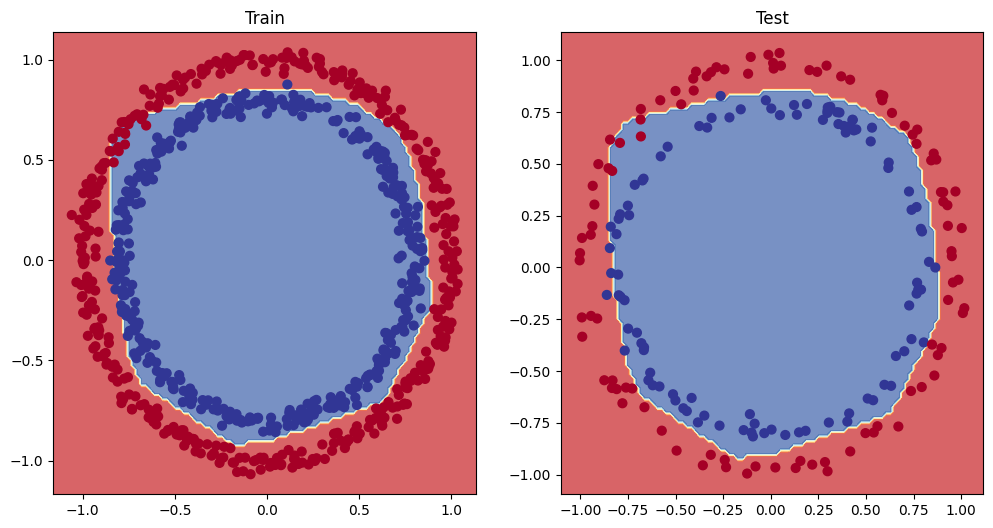

In [20]:
# Plot decision boundaries

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)